### Goal

In this chapter,

We will mix up the feature matching and findHomography from calib3d module to find known objects in a complex image.


In [45]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [60]:
original_image = cv2.imread('../images/berlin.jpg')
#lets crop the original_image
#Finding size of the image
height, width = original_image.shape[:2]
#Top  left of cropped rectangle
start_height, start_width = 0,0
#Bottom right of cropeed rectangle
end_height, end_width = int(height * .75), int(width * .65)

#Simply use indexing to crop out the rectangle we desire
cropped = original_image[start_height:end_height , start_width:end_width]
rotated_image = cv2.rotate(cropped, cv2.ROTATE_90_CLOCKWISE)

In [61]:
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(original_image,None)
kp2, des2 = sift.detectAndCompute(rotated_image,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

Now we set a condition that atleast 10 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. Otherwise simply show a message saying not enough matches are present

In [62]:
MIN_MATCH_COUNT = 10

In [63]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = original_image.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    rotated_image = cv2.polylines(rotated_image,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [64]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

In [65]:
img3 = cv2.drawMatches(original_image,kp1,rotated_image,kp2,good,None,**draw_params)

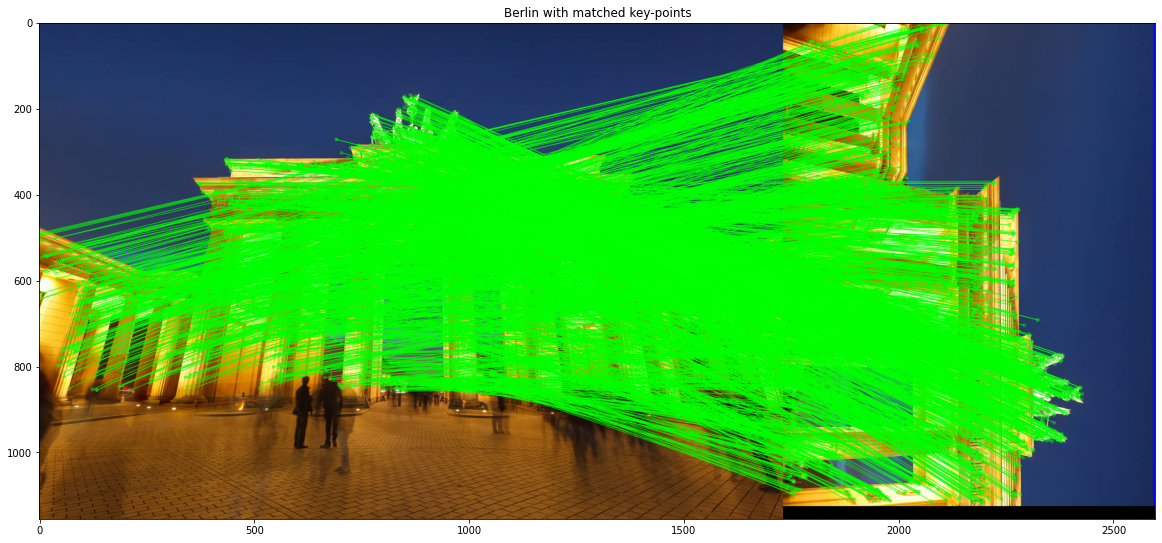

In [66]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.title('Berlin with matched key-points')
plt.show()